In [1]:
#install the dependencies
! pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhi2312","key":"bfa87cc9d37133e444bea58ac83219ff"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
# change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:29<00:00, 19.1MB/s]
100% 2.29G/2.29G [00:29<00:00, 82.8MB/s]


In [6]:
from zipfile import ZipFile
file_name = "chest-xray-pneumonia.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("Done")

Done


## Importing Necessary Libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
test_path = '/content/chest_xray/test'
train_path = '/content/chest_xray/train'
val_path = '/content/chest_xray/val'

In [9]:
import tensorflow 
#print(tf.__version__)

In [10]:
from tensorflow import keras
from tensorflow.keras.optimizers import  Adam, Adadelta
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization ,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob

In [11]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10, # Shift the pic width by a max of 5%
    height_shift_range=0.10, # Shift the pic height by a max of 5%
    rescale=1./255, # Rescale the image by normalzing it.
    shear_range=0.1, # Shear means cutting away part of the image (max 10%)
    zoom_range=0.1, # Zoom in by 10% max
    horizontal_flip=True, # Allo horizontal flipping
    fill_mode='nearest' # Fill in missing pixels with the nearest filled value
)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)


In [13]:
train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=32,
    #class_mode='binary'
    
)

Found 5216 images belonging to 2 classes.


In [14]:
test_gen = test_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=32,
    #class_mode='binary'
    
)

Found 624 images belonging to 2 classes.


In [15]:
val_gen = val_datagen.flow_from_directory(
    val_path,
    target_size=IMAGE_SIZE,
    batch_size=32,
    #class_mode='binary'
    
)

Found 16 images belonging to 2 classes.


In [16]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [17]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [18]:
# useful for getting number of output classes
folders = glob('/content/chest_xray/train/*')

In [19]:
# our layers - you can add more if you want

x = Flatten()(vgg.output)

In [20]:
prediction = Dense(2, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [21]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [22]:

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [23]:
# fit the model
# Run the cell. It will take some time to execute
cpt_filename = 'checkpoint_best.h5'
mcp = tensorflow.keras.callbacks.ModelCheckpoint(filepath=cpt_filename, monitor='val_accuracy',
                                         verbose=1, save_best_only=True, mode='max')

history = model.fit(
  train_gen,
  validation_data=test_gen,
  epochs=30,
  steps_per_epoch=len(train_gen),
  validation_steps=len(test_gen),
  callbacks=[mcp],
  verbose=2
)

Epoch 1/30

Epoch 00001: val_accuracy improved from -inf to 0.91667, saving model to checkpoint_best.h5
163/163 - 102s - loss: 0.2535 - accuracy: 0.9032 - val_loss: 0.2424 - val_accuracy: 0.9167
Epoch 2/30

Epoch 00002: val_accuracy did not improve from 0.91667
163/163 - 102s - loss: 0.1234 - accuracy: 0.9538 - val_loss: 0.4321 - val_accuracy: 0.8574
Epoch 3/30

Epoch 00003: val_accuracy did not improve from 0.91667
163/163 - 101s - loss: 0.1002 - accuracy: 0.9609 - val_loss: 0.2631 - val_accuracy: 0.9135
Epoch 4/30

Epoch 00004: val_accuracy did not improve from 0.91667
163/163 - 101s - loss: 0.0979 - accuracy: 0.9632 - val_loss: 0.2967 - val_accuracy: 0.9103
Epoch 5/30

Epoch 00005: val_accuracy did not improve from 0.91667
163/163 - 101s - loss: 0.0933 - accuracy: 0.9661 - val_loss: 0.6527 - val_accuracy: 0.8317
Epoch 6/30

Epoch 00006: val_accuracy did not improve from 0.91667
163/163 - 101s - loss: 0.0889 - accuracy: 0.9657 - val_loss: 0.3273 - val_accuracy: 0.9103
Epoch 7/30

Epo

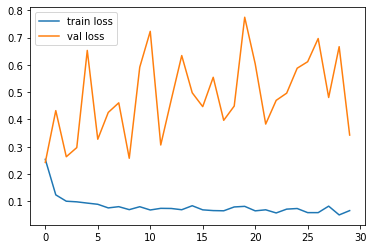

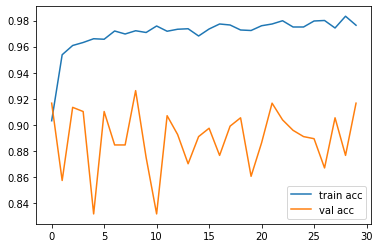

<Figure size 432x288 with 0 Axes>

In [24]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [25]:
predict = model.predict(test_gen)

In [ ]:
predict

In [26]:
prediction=np.argmax(predict,axis=1)

In [27]:
from sklearn.metrics import classification_report,confusion_matrix

In [28]:
print(classification_report(test_gen.classes,prediction))

              precision    recall  f1-score   support

           0       0.40      0.40      0.40       234
           1       0.64      0.64      0.64       390

    accuracy                           0.55       624
   macro avg       0.52      0.52      0.52       624
weighted avg       0.55      0.55      0.55       624



In [31]:
cm=confusion_matrix(test_gen.classes,prediction)
cm

array([[ 93, 141],
       [141, 249]])

In [32]:
sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.3974358974358974
Specificity :  0.6384615384615384


In [35]:
model.save('VGG16_New.h5')